# Mount drive and bucket
Todo: Remove in public version

In [1]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [2]:
import sys
import datetime
import logging

# nblog = open(f"/content/bigdata/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
# print(nblog)
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

#get_ipython().log.handlers[0].stream = nblog
#get_ipython().log.setLevel(logging.INFO)

%autosave 60

Autosaving every 60 seconds


In [3]:
# if COLAB:
#   from google.colab import drive
#   drive.mount('/content/drive')

In [4]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [5]:
# Todo: Check if possible in local docker
# from google.cloud import storage

In [6]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-03-28 14:32:59.224095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 14:32:59.655218: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-28 14:33:00.562774: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 14:33:00.562864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

TF Version is 2.10.0, ok!


In [7]:
from tensorflow import keras
# import tensorflow_gcs_config
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten #, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

In [8]:
import os
from os import listdir
from os.path import isfile, join

In [9]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random

In [10]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [11]:
# Set the checkpoint path for saving train progress
if COLAB:
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [12]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    #%cd /content/CryptoCrystalBall/JupyterDocker/notebooks
    %cd /content

In [13]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [14]:
try:
  from transformers import TFRobertaModel, RobertaConfig
except:
  # Important!: Version 4.23 does not work on TPU
  !pip install transformers==4.22

  from transformers import TFRobertaModel, RobertaConfig

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [15]:
# !pip uninstall -y tensorboard-plugin-profile

In [16]:
# # Required to do profiling
# !pip install tensorboard-plugin-profile

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [18]:
# # Get the current directory
# current_dir = os.getcwd()
# current_dir_splitted = current_dir.split(os.sep)

# Todo: is inside /content/CB in local docker
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [19]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [20]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [21]:
# Define the tick data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /content/DemoData


In [22]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /content/Documentation/Images


In [23]:
# Define a global random seed
RANDOM_SEED = 42

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [24]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 256

In [25]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 384

In [26]:
# A fixed number of features is used
FEATURES = 160

In [27]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [28]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the train dataset

In [29]:
# Get train file names - Only pick the ones ending with -USDT to prevent
# influence between different currencies
TRAIN_PATH = "/content/dataset/etffancy"

# Get all file names
ALL_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
ALL_FILES = sorted(ALL_FILES)

print(f"The train dataset contains {len(ALL_FILES)} files.")
print(ALL_FILES[:3])

The train dataset contains 1064 files.
['/content/dataset/etffancy/DE0002635265.csv', '/content/dataset/etffancy/DE0002635273.csv', '/content/dataset/etffancy/DE0002635281.csv']


In [30]:
# Split the dataset into train, test (trade algorithm train) and eval (trade algorithm test)
SPLIT_RANDOM_SEED = 666
TRAIN_SET_SIZE = 0.5
TEST_SET_SIZE = 0.25
# EVAL_SET_SIZE: The rest

random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
print(f"train_split_index: {train_split_index}")

test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
print(f"test_split_index: {test_split_index}")

TRAIN_FILES = ALL_FILES[:train_split_index]
TEST_FILES = ALL_FILES[train_split_index:test_split_index]
EVAL_FILES = ALL_FILES[test_split_index:]

train_split_index: 532
test_split_index: 798


---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  
Target values (y-data) from the data generator would not be necessary in this notebook, but since it cannot be switched off, the future direction and its derviation of the price have been chosen in `Y_TYPE_DICT` since they are not expensive to compute. A switch flag will be added in a future release.

In [31]:
# FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)
Y_TYPE_DICT["gain_timespan"] = 14
Y_TYPE_DICT["direction_ma_timespan"] = 14
Y_TYPE_DICT["derivation_ma_timespan"] = 14
Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 14,
 'direction_ma_timespan': 14,
 'derivation_ma_timespan': 14}

In [32]:
TARGET_FEATURE_CNT = 160 #256

In [33]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT)
XShape

(384, 256, 160)

In [34]:
import numpy as np
a = np.array([1,2,3,4])
a[[1,3]]

array([2, 4])

In [35]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorSignalsTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y'][:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)
        
      # 'Blow up' the X array to a 2**n size
      #_X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      #_X_new[:,:,:_X.shape[2]] = _X

      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [36]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

2023-03-28 14:33:02.845667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 14:33:02.921888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 14:33:02.922089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 14:33:02.924072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<PrefetchDataset element_spec=(TensorSpec(shape=(384, 256, 160), dtype=tf.float32, name=None), TensorSpec(shape=(384, 2), dtype=tf.float32, name=None))>

---
# Create the neural network

In the example, two Conv1D pyramids are used to extract features at different levels out of the feature and the time dimension.

It is also possible to use different architecures, like LSTM, Conv2D, Attention-Based ones or even NLP-based models. I have already tried many different ones and will publish them into the model zoo.

```
Todo: Create Model Zoo
```

```
Todo: Create Image of netwrok structure
```

In [37]:
# from keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D, UnitNormalization, UpSampling1D
from keras.layers import UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention, Dropout

In [38]:
# Create the FPNWithFScaledInput model
# Infos about the feature pyramid: https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c

def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttentionBiggerTimebased",
      "VERSION": "1_FutureOnly",
      "CNN_INITIAL_FILTERS": 64,
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 64,
      "HEAD_DENSE_SIZE": 32
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, TARGET_FEATURE_CNT), name='inputTicksAndIndicators', dtype='float32')
  inputTicksAndIndicators = Dropout(0.1, name='inputDropout')(inputTicksAndIndicators)

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # Permute it to Conv over Features
  #normalized = Permute((2, 1), name="PermuteInput")(normalized)

  # ----------------------------------------------------------------------------

  # As an example a 1D-CNN pyramid is used to extract higher-level features out
  # of the indicator+tick dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_1")(source_layer)
    
    res_net_element = Activation("relu",
                              name=f"ResNet_{i}_ReLU")(res_net_element)
    
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_2")(res_net_element)
    
    res_net_element = Add(name=f"ResNet_{i}_Add")([res_net_element, source_layer])
        
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"ResNet_{i}_Feature_Conv1D_FilterDimReduction")(res_net_element)

    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(2, activation="tanh", name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 128, 64)
feature_conv_attentioned.shape: (None, 128, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 64, 128)
feature_conv_attentioned.shape: (None, 64, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 32, 256)
feature_conv_attentioned.shape: (None, 32, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 512)
feature_conv_attentioned.shape: (None, 16, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 1024)
feature_conv_attentioned.shape: (None, 8, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 2048)
feature_conv_attentioned.shape: (None, 4, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 4, 256)
Building feat

# Train the model

### Train strategy in the paper
https://huggingface.co/roberta-base

The model was trained on 1024 V100 GPUs for 500K steps with a batch size of 8K and a sequence length of 512. The optimizer used is Adam with a learning rate of 6e-4, β1=0.9\beta_{1} = 0.9β1​=0.9, β2=0.98\beta_{2} = 0.98β2​=0.98 and ϵ=1e−6\epsilon = 1e-6ϵ=1e−6, a weight decay of 0.01, learning rate warmup for 24,000 steps and linear decay of the learning rate after.

In [39]:
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttentionBiggerTimebased_1_FutureOnly_GPU_256LB'

In [40]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-04,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [41]:
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = ["mse"], 
    metrics=["mae"])

In [42]:
#@title CustomCallback
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

      fp = os.path.join(_save_folder, "c.pickle")
      with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
      logging.info(f"Saved optimizer config to '{fp}'")

      # Save optimizer weights
      # w = copy.deepcopy(self.model.optimizer.get_weights())

      fp = os.path.join(_save_folder, "w.pickle")
      with open(fp, "wb") as handle:
        # with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
      logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [43]:
gc.collect()

9686

In [44]:
epoch_add = 31

In [45]:
CALLBACK_EVERY_N_BATCHES = 2000

In [46]:
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [47]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [48]:
%reload_ext tensorboard

The TensorBoard UI is displayed in a browser window. In this colab, perform the following steps to prepare to capture profile information.
1.  Click on the dropdown menu box on the top right side and scroll down and click PROFILE. A new window appears that shows: **No profile data was found** at the top.
1.  Click on the CAPTURE PROFILE button. A new dialog appears. The top input line shows: **Profile Service URL or TPU name**. Copy and paste the Profile Service URL (the service_addr value shown before launching TensorBoard) into the top input line. While still on the dialog box, start the training with the next step.
1.  Click on the next colab cell to start training the model.
1.  Watch the output from the training until several epochs have completed. This allows time for the profile data to start being collected. Return to the dialog box and click on the CAPTURE button. If the capture succeeds, the page will auto refresh and redirect you to the profiling results.

In [49]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/bigdata/log",log_dir.split("/")[-1])

log_dir

'/content/bigdata/log/FPNWithAttentionBiggerTimebased_1_FutureOnly_GPU_256LB20230328-143305'

In [50]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-03-28 14:33:05.463953: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-28 14:33:05.463974: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-28 14:33:05.465116: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-03-28 14:33:05.465349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-03-28 14:33:05.591371: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-28 14:33:05.591547: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [51]:
#model.load_weights("/content/bigdata/chk/FPNWithAttentionBigger_3_FutureOnly_GPU_256LB/cp_daily_valid_33_end/model.h5")

In [52]:
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

In [53]:
# model.fit(tfGenTraining,
#           epochs=1,
#           verbose = 1,
#           callbacks=[tensorboard_callback, cc])

In [54]:
# model.optimizer.learning_rate = 5e-6

In [55]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>

In [ ]:
model.fit(tfGenTraining,
          epochs=30,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

Epoch 1/30


INFO:root:File 'IE00B6X2VY59.csv' loaded, 531 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 530 left
INFO:root:File 'DE000A0F5UF5.csv' loaded, 529 left
INFO:root:File 'DE000ETFL441.csv' loaded, 528 left
INFO:root:File 'LU1781541179.csv' loaded, 527 left
INFO:root:File 'LU1650487926.csv' loaded, 526 left
INFO:root:File 'LU1285960032.csv' loaded, 525 left
INFO:root:File 'IE00B1FZSD53.csv' loaded, 524 left
2023-03-28 14:33:28.677828: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
INFO:root:File 'IE00B5KQNG97.csv' loaded, 523 left
2023-03-28 14:33:31.724236: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-28 14:33:35.792090: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory tryi

      4/Unknown - 28s 575ms/step - loss: 2.8645e-04 - mae: 0.0069

2023-03-28 14:33:38.092162: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-28 14:33:38.092192: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
INFO:root:File 'IE00BYM31M36.csv' loaded, 522 left


      6/Unknown - 31s 831ms/step - loss: 2.5536e-04 - mae: 0.0067WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1696s vs `on_train_batch_end` time: 0.5256s). Check your callbacks.


      8/Unknown - 32s 758ms/step - loss: 2.6055e-04 - mae: 0.0069

INFO:root:File 'LU2082996542.csv' loaded, 521 left


      9/Unknown - 33s 744ms/step - loss: 2.7678e-04 - mae: 0.0070

In [60]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorEval(fileList):
  # Initialize the FileListToDataStream generator
  dataStreamEval= DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamEval)
      _X = ne['X']
      _y = _y = ne['y']#[:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)
    
      # 'Blow up' the X array to a 2**n size
      #_X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      #_X_new[:,:,:_X.shape[2]] = _X

      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [61]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[TRAIN_FILES[4]]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 4)
                                                   )
                                               )
tfGenEval

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 256, 160), dtype=tf.float32, name=None), TensorSpec(shape=(384, 4), dtype=tf.float32, name=None))>

In [ ]:
# ne[0].shape

In [ ]:
# ne[1].shape

In [ ]:
# plt.plot(ne[1][:,0])

In [ ]:
# plt.plot(ne[1][:,1])

In [ ]:
# evl = model.evaluate(tfGenEval)
# evl

In [62]:
p = model.predict(tfGenEval)
p *= 10.0
p.shape

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


     14/Unknown - 7s 294ms/step

14/14 [==============================] - 7s 307ms/step


(5376, 2)

In [63]:
def getPastDataFromGen(genIn, predictedShapeIn):
    it = genIn.as_numpy_iterator()

    y_past_data = np.empty((predictedShapeIn[0], 2))
    i = 0

    try:
        while (ne := next(it)):
            #print(i)
            y_past_data[i:i+ne[1].shape[0],0] = ne[1][:,0]
            y_past_data[i:i+ne[1].shape[0],1] = ne[1][:,2]

            i += ne[1].shape[0]

    except StopIteration:
        pass

    return y_past_data
    
y_past_data = getPastDataFromGen(tfGenEval, p.shape)
y_past_data.shape

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


(5376, 2)

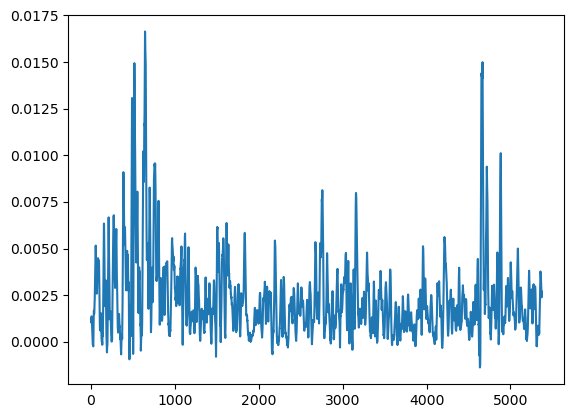

In [64]:
plt.plot(y_past_data[:,0])

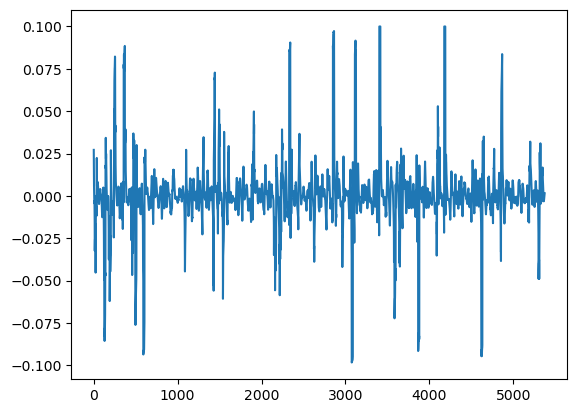

In [65]:
plt.plot(y_past_data[:,1])

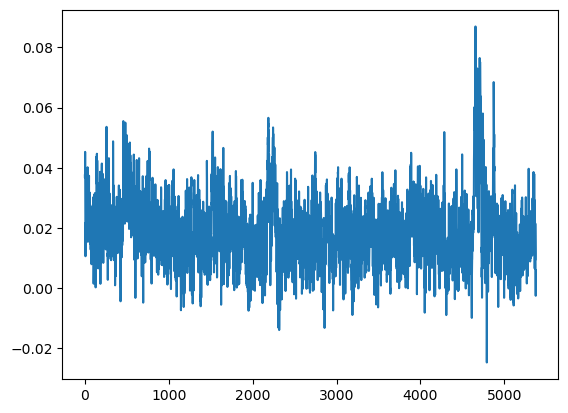

In [66]:
plt.plot(p[:,0])

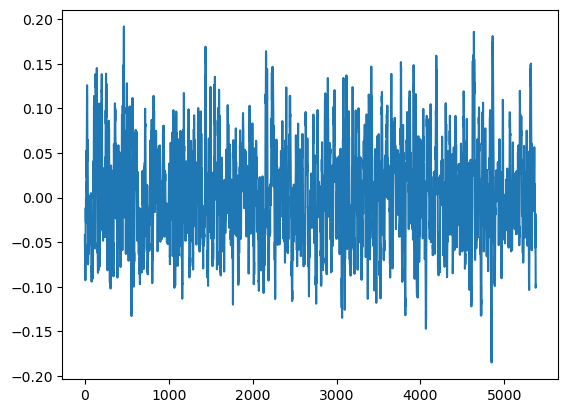

In [67]:
plt.plot(p[:,1])

In [69]:
p.shape

(5376, 2)

In [70]:
tickDF = pd.read_csv(TRAIN_FILES[1])
tickDF

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [71]:
tickDF.shape[0] - p.shape[0]

-55

In [72]:
tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
tickDFcropped

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [73]:
# p_dir = p[:,0]
# p_dir_derivation = p[:,1]

p_future = p[:,0]
p_future_derivation = p[:,1]

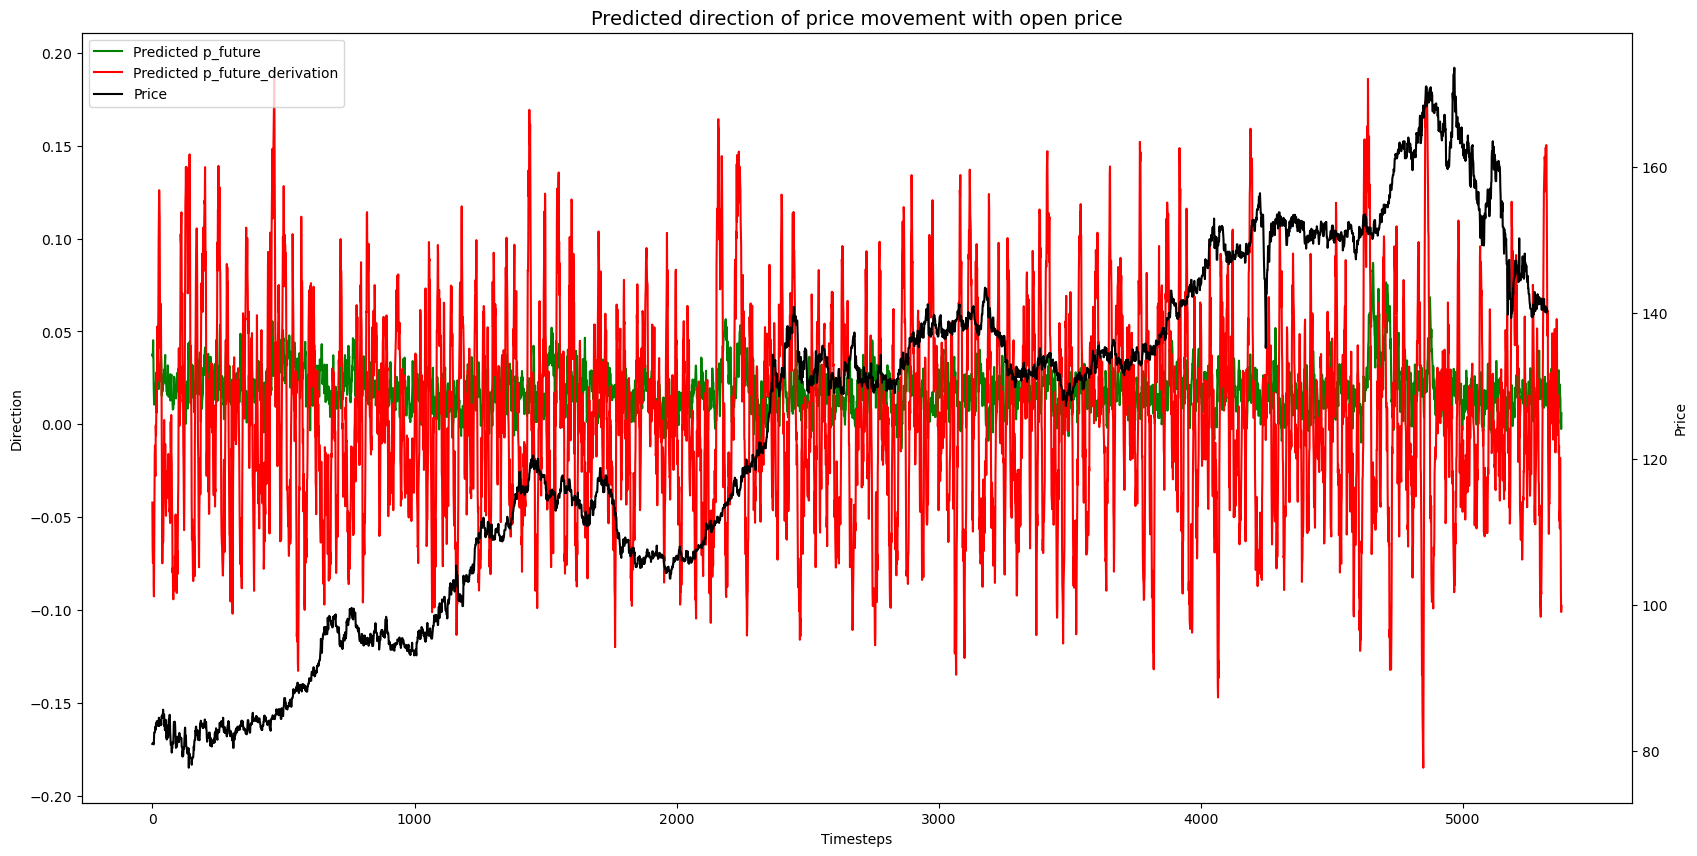

In [78]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_future, color="green", label="Predicted p_future")
_ = ax1.plot(p_future_derivation, color="red", label="Predicted p_future_derivation")
# _ = ax1.plot(p_neutral, color="gray", label="Predicted neutral")

ax2 = ax1.twinx()

ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [75]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

NameError: name 'p_past_gain' is not defined

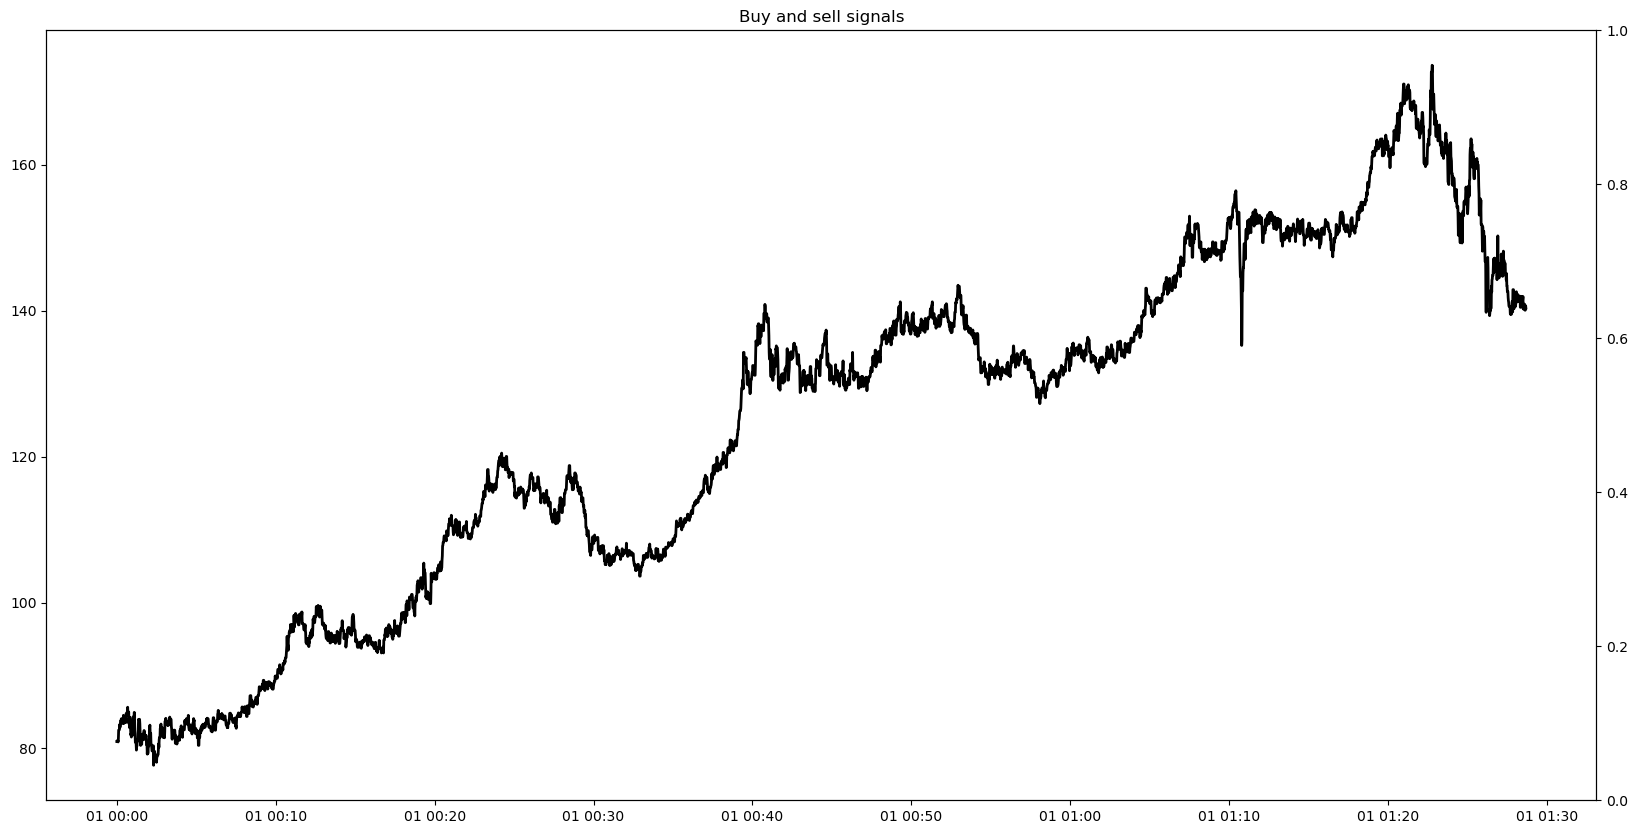

In [79]:
#@title Plot buy and sell signals
chart_name="Buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

_ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_past_gain >= SELL_SIGNAL_THRESHOLD_PAST
yCategoryRise = (p_future_gain > p_past_gain) & (p_past_gain <= BUY_SIGNAL_THRESHOLD_FUTURE) #(p_future_gain >= BUY_SIGNAL_THRESHOLD_FUTURE)

ax2.fill_between(x_datetimes, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes, p_future_gain, color="blue", label="Predicted future gain")
# _ = ax3.plot(x_datetimes, 10.0*p_dir_derivation, color="red", label="10.0 * Predicted price direction derivation")
# ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes), np.max(x_datetimes)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Add predictions to tick tables

In [ ]:
stop

In [ ]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [80]:
!mkdir /content/dataset/etffancy/FPNWithAttentionBiggerTimebased_1_FutureOnly
!mkdir /content/dataset/etffancy/FPNWithAttentionBiggerTimebased_1_FutureOnly/test
!mkdir /content/dataset/etffancy/FPNWithAttentionBiggerTimebased_1_FutureOnly/eval

In [81]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

#fileList = EVAL_FILES
#PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBiggerTimebased_1_FutureOnly/eval"

fileList = TEST_FILES
PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBiggerTimebased_1_FutureOnly/test"

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                           (BATCH_SIZE, 4)
                                                           )
                                                       )
        p = model.predict(tfGenEval, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]
        
        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
        
        # Add the predicted future gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain
        tickDFcropped.loc[:,"p_future_gain_derivation"] = p_future_gain_derivation
        
        # Get the (known) past data
        y_past_data = getPastDataFromGen(tfGenEval, p.shape)

        # Add the past gain
        tickDFcropped.loc[:,"p_past_gain"] = y_past_data[:,0]
        tickDFcropped.loc[:,"p_past_gain_derivation"] = y_past_data[:,1]

        # Save the DF
        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

  0%|                                                                                                                                                                                                                 | 0/266 [00:00<?, ?it/s]INFO:root:
File name: '/content/dataset/etffancy/LU1598688189.csv' for index 0
INFO:root:File 'LU1598688189.csv' loaded, 0 left
INFO:root:p.shape: (6144, 2)
INFO:root:File 'LU1598688189.csv' loaded, 0 left
INFO:root:Saved the predicted data.
  0%|▋                                                                                                                                                                                                      | 1/266 [00:15<1:08:00, 15.40s/it]INFO:root:
File name: '/content/dataset/etffancy/IE00B8CJW150.csv' for index 1
INFO:root:File 'IE00B8CJW150.csv' loaded, 0 left
INFO:root:p.shape: (3072, 2)
INFO:root:File 'IE00B8CJW150.csv' loaded, 0 left
INFO:root:Saved the predicted data.
  1%|█▌                                 

In [82]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

fileList = EVAL_FILES
PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBiggerTimebased_1_FutureOnly/eval"

# fileList = TEST_FILES
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBiggerTimebased_1_FutureOnly/test"

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                           (BATCH_SIZE, 4)
                                                           )
                                                       )
        p = model.predict(tfGenEval, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]
        
        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
        
        # Add the predicted future gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain
        tickDFcropped.loc[:,"p_future_gain_derivation"] = p_future_gain_derivation
        
        # Get the (known) past data
        y_past_data = getPastDataFromGen(tfGenEval, p.shape)

        # Add the past gain
        tickDFcropped.loc[:,"p_past_gain"] = y_past_data[:,0]
        tickDFcropped.loc[:,"p_past_gain_derivation"] = y_past_data[:,1]

        # Save the DF
        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

  0%|                                                                                                                                                                                                                 | 0/266 [00:00<?, ?it/s]INFO:root:
File name: '/content/dataset/etffancy/IE00B4KBBD01.csv' for index 0
INFO:root:File 'IE00B4KBBD01.csv' loaded, 0 left
INFO:root:p.shape: (1536, 2)
INFO:root:File 'IE00B4KBBD01.csv' loaded, 0 left
INFO:root:Saved the predicted data.
  0%|▊                                                                                                                                                                                                        | 1/266 [00:04<21:26,  4.86s/it]INFO:root:
File name: '/content/dataset/etffancy/IE00B0M62Y33.csv' for index 1
INFO:root:File 'IE00B0M62Y33.csv' loaded, 0 left
INFO:root:p.shape: (5760, 2)
INFO:root:File 'IE00B0M62Y33.csv' loaded, 0 left
INFO:root:Saved the predicted data.
  1%|█▌                                 